In [20]:
import pandas as pd
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import gmean

In [21]:
import yfinance as yf

In [22]:
ticker = "^XSP"
xsp = yf.Ticker(ticker)
opt = xsp.option_chain('2024-12-20')
opt

Options(calls=        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   XSP241220C00250000 2024-03-07 16:10:44+00:00   250.0     271.60  267.93   
1   XSP241220C00260000 2024-03-28 19:16:28+00:00   260.0     272.95    0.00   
2   XSP241220C00280000 2023-09-08 16:03:10+00:00   280.0     181.00  161.05   
3   XSP241220C00300000 2024-03-07 16:10:45+00:00   300.0     224.21  220.52   
4   XSP241220C00310000 2023-06-09 18:18:25+00:00   310.0     140.00    0.00   
..                 ...                       ...     ...        ...     ...   
74  XSP241220C00520000 2024-04-30 15:21:30+00:00   520.0      25.21   29.86   
75  XSP241220C00530000 2024-04-30 15:21:30+00:00   530.0      19.78   23.93   
76  XSP241220C00540000 2024-05-02 19:34:13+00:00   540.0      13.97   18.68   
77  XSP241220C00725000 2024-03-04 16:45:18+00:00   725.0       0.09    0.00   
78  XSP241220C00730000 2024-03-11 14:43:55+00:00   730.0       0.09    0.03   

       ask  change  percentChange  vo

In [27]:
S0_xsp = 456.78
opt_call = opt.calls.set_index('contractSymbol')

In [28]:
# Calculate real price and time to maturity

real_call_p = (16.94 + 17.56)/2

import datetime
lastTradeDate = datetime.datetime(2023,11,30)
expDate = datetime.datetime(2024,12,20)
time_to_maturity = ((expDate - lastTradeDate).days)/365
time_to_maturity # in years

1.0575342465753426

In [29]:
def AsianSim(S0, K, T, r, sigma, N, M, security_type):
    np.random.seed(10)  # Fixing the seed for reproducibility

    # Time step
    delta_t = T / N

    # Simulate the random components of the stock price paths
    random_matrix = np.random.normal(0, 1, (N, M))

    # Precompute constants for the simulation
    drift = (r - 0.5 * sigma**2) * delta_t
    diffusion = sigma * np.sqrt(delta_t)

    # Initialize the stock price matrix
    stock_prices = np.zeros((N + 1, M))
    stock_prices[0, :] = S0

    # Generate the stock price paths
    for t in range(1, N + 1):
        stock_prices[t, :] = stock_prices[t - 1, :] * np.exp(drift + diffusion * random_matrix[t - 1, :])

    # Calculate the arithmetic average of the stock prices for each simulation
    arithmetic_average = np.mean(stock_prices[1:, :], axis=0)  # Exclude the initial price

    # Calculate payoffs based on the type of option
    if security_type == 'call':
        payoffs = np.maximum(arithmetic_average - K, 0)
    else:
        payoffs = np.maximum(K - arithmetic_average, 0)

    # Discount the average payoff back to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)
    std_error = np.std(np.exp(-r * T) * payoffs) / np.sqrt(M)

    return option_price, std_error

# Example parameters

# Parameters
S0 = S0_xsp       # initial stock price
K = 510         # strike price
T =  time_to_maturity        # time to maturity in years
r = 0.04031        # risk-free rate
sigma = 0.16668     # volatility
N = 500        # number of time steps
M = 10000       # number of simulations


# Call option pricing
call_price, Standard_Error_c= AsianSim(S0, K, T, r, sigma, N, M, 'call')
print(f"Estimated Asian Call Option Price: {call_price:.4f} Esmated Standard Error:{Standard_Error_c:4f}")

# Put option pricing
put_price, Standard_Error_p = AsianSim(S0, K, T, r, sigma, N, M, 'put')
print(f"Estimated Asian Put Option Price: {put_price:.4f} Esmated Standard Error:{Standard_Error_p:4f}")


Estimated Asian Call Option Price: 4.7833 Esmated Standard Error:0.147645
Estimated Asian Put Option Price: 46.7758 Esmated Standard Error:0.365913


In [8]:
# Replications levels
replications = [1000, 10000, 100000, 1000000]

results = []
for M in replications:
    price, error = AsianSim(S0, K, T, r, sigma, N, M,'call')
    results.append((M, price, error))
# Display results
print("Number of Paths | Estimated Price | Standard Error")
for result in results:
    print(f"{result[0]:>15} | {result[1]:>15.4f} | {result[2]:>14.4f}")

Number of Paths | Estimated Price | Standard Error
           1000 |          4.4245 |         0.4531
          10000 |          4.7833 |         0.1476
         100000 |          4.8987 |         0.0471
        1000000 |          4.8767 |         0.0149


In [61]:
N_2 = [252, 500, 1000, 2000, 10000,30000]
M_2 = [500, 1000, 2000, 10000, 20000,30000]

price_simulation = []
Stand_Error=[]
for i in N_2:
  for j in M_2:
    # print(i, j)
    p,s = AsianSim(S0, K, T, r, sigma, i, j, security_type = 'call')
    price_simulation.append(p)
    Stand_Error.append(s)

results_p = pd.DataFrame(np.array(price_simulation).reshape((6,6)), columns = M_2, index = N_2)
results_p

,500,1000,2000,10000,20000,30000
252,5.142281,4.644185,4.542999,4.764185,4.716312,4.884772
500,4.781955,4.424472,4.855075,4.783325,4.820062,4.836738
1000,4.361778,4.810042,4.944360,4.885688,4.844012,4.891433
2000,4.718035,4.672857,4.944437,4.919785,4.874339,4.973256
10000,4.670074,5.265812,5.408878,4.926131,4.795679,5.046402
30000,5.565791,5.687507,5.271123,4.876523,4.890530,5.043582


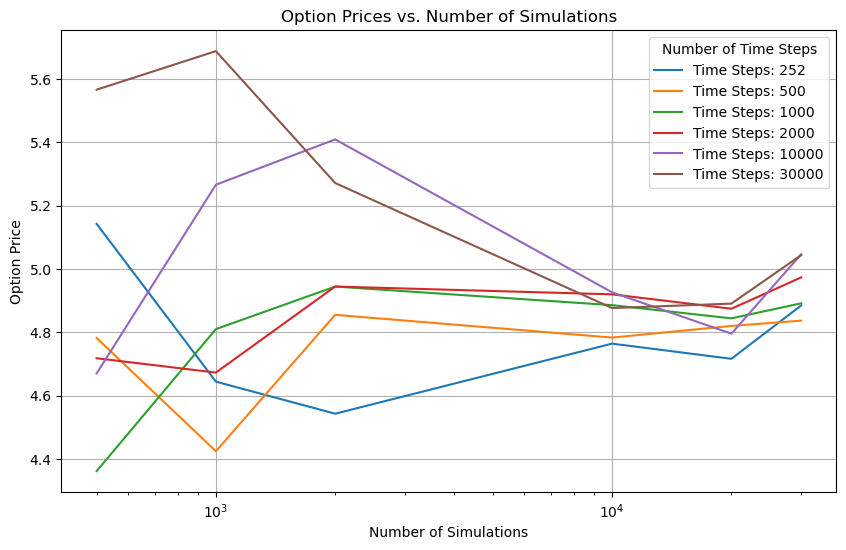

In [67]:
# Plotting
plt.figure(figsize=(10, 6))
for n in results_p.index:
    plt.plot(results_p.columns, results_p.loc[n, :], label=f'Time Steps: {n}')

plt.title('Option Prices vs. Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Option Price')
plt.legend(title='Number of Time Steps')
plt.grid(True)
plt.xscale('log')  # Optional: Logarithmic scale for better visualization if needed
plt.show()

In [69]:
results_s=pd.DataFrame(np.array(Stand_Error).reshape((6,6)), columns = M_2, index = N_2)
results_s

,500,1000,2000,10000,20000,30000
252,0.684492,0.463050,0.309850,0.146277,0.103245,0.085640
500,0.625229,0.453060,0.345277,0.147645,0.103639,0.084748
1000,0.597187,0.477372,0.347859,0.147660,0.103436,0.085421
2000,0.663155,0.452524,0.342479,0.147720,0.103727,0.086875
10000,0.677352,0.509830,0.372245,0.149759,0.103578,0.087794
30000,0.733741,0.545271,0.344751,0.148182,0.104067,0.086944


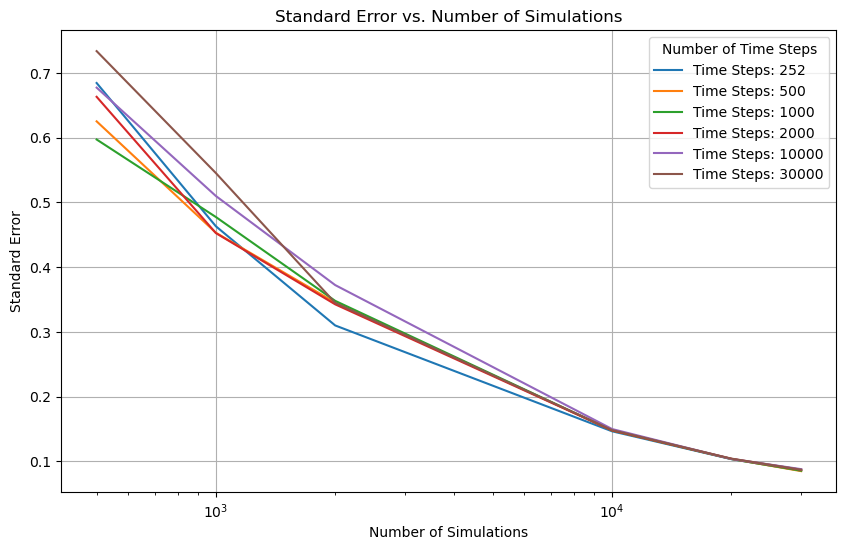

In [70]:
# Plotting
plt.figure(figsize=(10, 6))
for n in results_s.index:
    plt.plot(results_s.columns, results_s.loc[n, :], label=f'Time Steps: {n}')

plt.title('Standard Error vs. Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Standard Error')
plt.legend(title='Number of Time Steps')
plt.grid(True)
plt.xscale('log')  # Optional: Logarithmic scale for better visualization if needed
plt.show()

Evaluate the impact of parameters such as volatility σ, risk-free rate r, and maturity 𝑇 on the option price.

In [11]:
# Vary volatility 
for new_sigma in [0.1, 0.2, 0.3, 0.4]:
    price, std = AsianSim(S0, K, T, r, new_sigma, N, M, 'call')
    print(f"Volatility: {new_sigma}, Estimated Call Price: {price:.4f}")

# Vary risk-free rate
for new_r in [0.01, 0.05, 0.1]:
    price,std = AsianSim(S0, K, T, new_r, sigma, N, M, 'call')
    print(f"Risk-Free Rate: {new_r}, Estimated Call Price: {price:.4f}")

# Vary maturity
for new_T in [0.5, 1.0, 2.0]:
    price,std = AsianSim(S0, K, new_T, r, sigma, N, M, 'call')
    print(f"Maturity: {new_T}, Estimated Call Price: {price:.4f}")

Volatility: 0.1, Estimated Call Price: 0.8816
Volatility: 0.2, Estimated Call Price: 7.5863
Volatility: 0.3, Estimated Call Price: 16.9625
Volatility: 0.4, Estimated Call Price: 27.1696
Risk-Free Rate: 0.01, Estimated Call Price: 3.6670
Risk-Free Rate: 0.05, Estimated Call Price: 5.3201
Risk-Free Rate: 0.1, Estimated Call Price: 8.0913
Maturity: 0.5, Estimated Call Price: 1.0764
Maturity: 1.0, Estimated Call Price: 4.4365
Maturity: 2.0, Estimated Call Price: 12.4371


In [17]:
# Variance Reduction 

In [30]:
def enhanced_asian_option_price(S0, K, T, r, sigma, N, M, option_type='call'):
    dt = T / N
    paths = np.zeros((M, N+1))
    paths[:, 0] = S0
    
    # Generate paths
    for t in range(1, N+1):
        Z = np.random.standard_normal(M)
        paths[:, t] = paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    # Calculate the arithmetic average
    arithmetic_avg = np.mean(paths[:, 1:], axis=1)
    
    # Calculate the geometric average
    geometric_avg = np.exp(np.mean(np.log(paths[:, 1:]), axis=1))

    # Calculate payoffs for both averages
    arithmetic_payoffs = np.maximum(arithmetic_avg - K, 0) if option_type == 'call' else np.maximum(K - arithmetic_avg, 0)
    geometric_payoffs = np.maximum(geometric_avg - K, 0) if option_type == 'call' else np.maximum(K - geometric_avg, 0)
    
    # Analytical price for geometric Asian options (as control)
    # Placeholder for actual analytical formula here
    c = np.mean(geometric_payoffs)
    
    # Using control variates
    beta = np.cov(arithmetic_payoffs, geometric_payoffs)[0, 1] / np.var(geometric_payoffs)
    enhanced_payoffs = arithmetic_payoffs - beta * (geometric_payoffs - c)
    
    # Discount and average the payoffs
    option_price = np.exp(-r * T) * np.mean(enhanced_payoffs)
    
    std_error_enhanced = np.std(np.exp(-r * T) * enhanced_payoffs) / np.sqrt(M)


    return option_price,np.corrcoef(arithmetic_payoffs, geometric_payoffs)[0, 1],std_error_enhanced

# Pricing the option with control variates
enhanced_price,coeff,std_error_enhanced = enhanced_asian_option_price(S0, K, T, r, sigma, N, M)
print(f"Estimated Asian Call Option Price (Enhanced with Control Variates): {enhanced_price:.4f}")
print(f"Estimated Asian Call Coefficient (Enhanced with Control Variates): {coeff:.4f}")
print(f"Estimated Asian Call Standard Error (Enhanced with Control Variates): {std_error_enhanced:.4f}")

# Parameters
S0 = S0_xsp       # initial stock price
K = 510         # strike price
T =  time_to_maturity        # time to maturity in years
r = 0.04031        # risk-free rate
sigma = 0.16668     # volatility
N = 500        # number of time steps
M = 10000       # number of simulations

Estimated Asian Call Option Price (Enhanced with Control Variates): 5.0450
Estimated Asian Call Coefficient (Enhanced with Control Variates): 0.9992
Estimated Asian Call Standard Error (Enhanced with Control Variates): 0.0062


In [39]:
# Replications levels
replications = [1000, 10000, 100000, 1000000]

results = []
for M in replications:
    price, corff, error = enhanced_asian_option_price(S0, K, T, r, sigma, N, M,'call')
    results.append((M, price, error))
# Display results
print("Number of Paths | Estimated Enhanced Price | Enhanced Standard Error")
for result in results:
    print(f"{result[0]:>15} | {result[1]:>15.4f} | {result[2]:>14.4f}")

Number of Paths | Estimated Enhanced Price | Enhanced Standard Error
           1000 |          5.1912 |         0.0219
          10000 |          4.9431 |         0.0064
         100000 |          4.8951 |         0.0020
        1000000 |          4.8621 |         0.0006


In [72]:
# Vary volatility 
for new_sigma in [0.1, 0.2, 0.3, 0.4]:
    price, std,coeff = enhanced_asian_option_price(S0, K, T, r, new_sigma, N, M, 'call')
    print(f"Volatility: {new_sigma}, Estimated Enhanced Call Price: {price:.4f}")

# Vary risk-free rate
for new_r in [0.01, 0.05, 0.1]:
    price,std,coeff = enhanced_asian_option_price(S0, K, T, new_r, sigma, N, M, 'call')
    print(f"Risk-Free Rate: {new_r}, Estimated Enhanced Call Price: {price:.4f}")

# Vary maturity
for new_T in [0.5, 1.0, 2.0]:
    price,std,coeff = enhanced_asian_option_price(S0, K, new_T, r, sigma, N, M, 'call')
    print(f"Maturity: {new_T}, Estimated Enhanced Call Price: {price:.4f}")

Volatility: 0.1, Estimated Enhanced Call Price: 0.8808
Volatility: 0.2, Estimated Enhanced Call Price: 7.5500
Volatility: 0.3, Estimated Enhanced Call Price: 16.9275
Volatility: 0.4, Estimated Enhanced Call Price: 27.1395
Risk-Free Rate: 0.01, Estimated Enhanced Call Price: 3.6502
Risk-Free Rate: 0.05, Estimated Enhanced Call Price: 5.3037
Risk-Free Rate: 0.1, Estimated Enhanced Call Price: 8.0936
Maturity: 0.5, Estimated Enhanced Call Price: 1.0678
Maturity: 1.0, Estimated Enhanced Call Price: 4.4082
Maturity: 2.0, Estimated Enhanced Call Price: 12.4110


# Comparison between two methods 

In [47]:
import time
import numpy as np

# Simulation parameters
M_values =1000,10000,100000,500000, 1000000

results = []

for M in M_values:
    # Basic Monte Carlo
    start_time = time.time()
    basic_price, std_error_basic = AsianSim(S0, K, T, r, sigma, N, M, 'call')
    basic_duration = time.time() - start_time

    # Enhanced Monte Carlo with Control Variates
    start_time = time.time()
    enhanced_price, correlation_coeff,std_error_enhanced = enhanced_asian_option_price(S0, K, T, r, sigma, N, M)
    enhanced_duration = time.time() - start_time

    # Collect results
    results.append({
        'M': M,
        'Basic Price': basic_price,
        'Basic Std Error': std_error_basic,
        'Basic Duration': basic_duration,
        'Enhanced Price': enhanced_price,
        'Correlation Coefficient': correlation_coeff,
        'Enhanced Std Error': std_error_enhanced,
        'Enhanced Duration': enhanced_duration
    })

# Display results
print("Replications | Basic Price | Basic Std Error | Basic Time | Enhanced Price | Enhanced Std Error | Enhanced Time | Correlation")
for result in results:
    print(f"{result['M']} | {result['Basic Price']:.4f} | {result['Basic Std Error']:.4f} | {result['Basic Duration']:.4f} s | "
          f"{result['Enhanced Price']:.4f} | {result['Enhanced Std Error']:.4f}| {result['Enhanced Duration']:.4f} s | {result['Correlation Coefficient']:.4f} ")


Replications | Basic Price | Basic Std Error | Basic Time | Enhanced Price | Enhanced Std Error | Enhanced Time | Correlation
1000 | 4.4245 | 0.4531 | 0.0277 s | 4.8726 | 0.0187| 0.0291 s | 0.9993 
10000 | 4.7833 | 0.1476 | 0.1323 s | 5.0450 | 0.0062| 0.1375 s | 0.9992 
100000 | 4.8987 | 0.0471 | 1.4386 s | 4.8741 | 0.0020| 1.6815 s | 0.9991 
500000 | 4.9121 | 0.0211 | 8.4735 s | 4.8502 | 0.0009| 11.5418 s | 0.9991 
1000000 | 4.8767 | 0.0149 | 31.5860 s | 4.8684 | 0.0006| 747.5401 s | 0.9991 


In [48]:
# Convert results to DataFrame for easier plotting
df = pd.DataFrame(results)
print(df)

         M  Basic Price  Basic Std Error  Basic Duration  Enhanced Price  \
0     1000     4.424472         0.453060        0.027659        4.872550   
1    10000     4.783325         0.147645        0.132341        5.044995   
2   100000     4.898734         0.047109        1.438637        4.874127   
3   500000     4.912115         0.021127        8.473475        4.850163   
4  1000000     4.876661         0.014862       31.585975        4.868428   

   Correlation Coefficient  Enhanced Std Error  Enhanced Duration  
0                 0.999272            0.018737           0.029052  
1                 0.999154            0.006229           0.137472  
2                 0.999101            0.001995           1.681524  
3                 0.999087            0.000893          11.541785  
4                 0.999079            0.000638         747.540064  


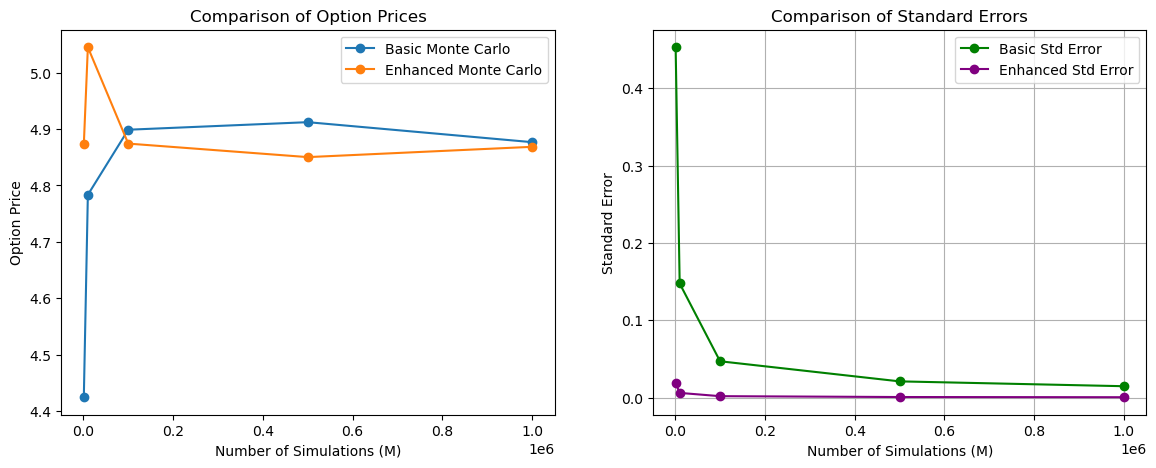

<Figure size 640x480 with 0 Axes>

In [40]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(df['M'], df['Basic Price'], label='Basic Monte Carlo', marker='o')
plt.plot(df['M'], df['Enhanced Price'], label='Enhanced Monte Carlo', marker='o')
plt.xlabel('Number of Simulations (M)')
plt.ylabel('Option Price')
plt.title('Comparison of Option Prices')
plt.legend()
#plt.grid(True)
#plt.show()

plt.subplot(1, 2, 2)
#plt.figure(figsize=(14, 5))
plt.plot(df['M'], df['Basic Std Error'], label='Basic Std Error', marker='o', color='green')
plt.plot(df['M'], df['Enhanced Std Error'], label='Enhanced Std Error', marker='o', color='purple')
plt.xlabel('Number of Simulations (M)')
plt.ylabel('Standard Error')
plt.title('Comparison of Standard Errors')
plt.legend()
plt.grid(True)
plt.show()

plt.tight_layout()
plt.show()

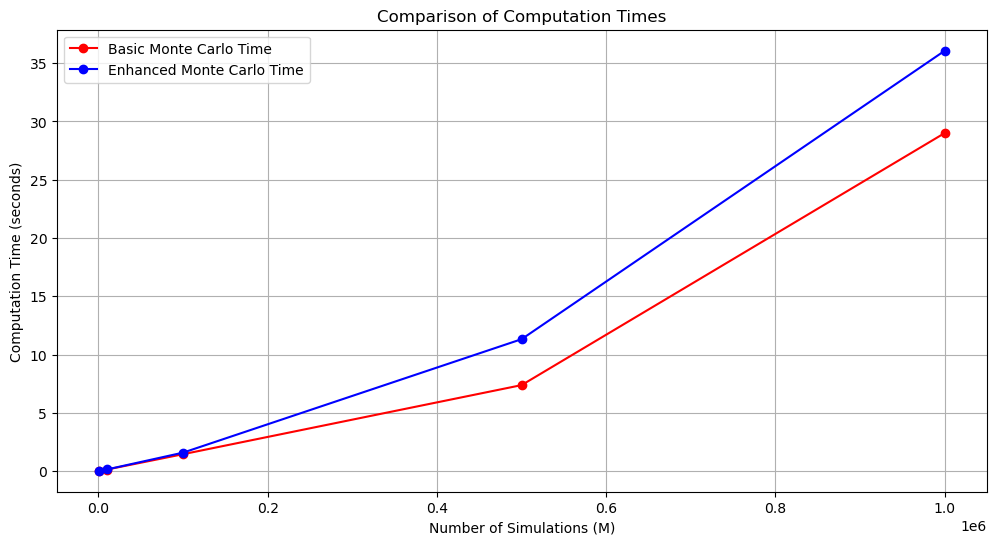

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(df['M'], df['Basic Duration'], label='Basic Monte Carlo Time', marker='o', color='red')
plt.plot(df['M'], df['Enhanced Duration'], label='Enhanced Monte Carlo Time', marker='o', color='blue')
plt.xlabel('Number of Simulations (M)')
plt.ylabel('Computation Time (seconds)')
plt.title('Comparison of Computation Times')
plt.legend()
plt.grid(True)
plt.show()

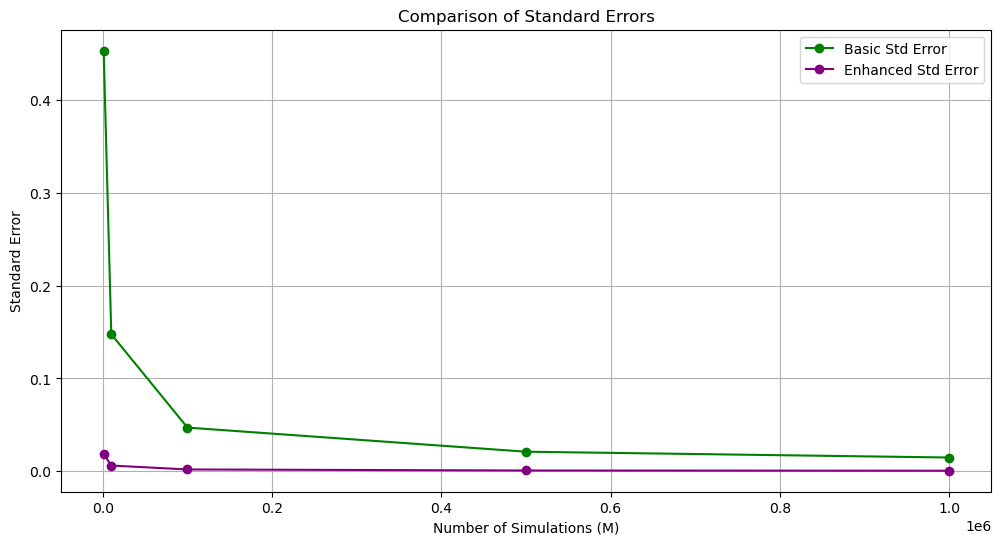

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(df['M'], df['Basic Std Error'], label='Basic Std Error', marker='o', color='green')
plt.plot(df['M'], df['Enhanced Std Error'], label='Enhanced Std Error', marker='o', color='purple')
plt.xlabel('Number of Simulations (M)')
plt.ylabel('Standard Error')
plt.title('Comparison of Standard Errors')
plt.legend()
plt.grid(True)
plt.show()

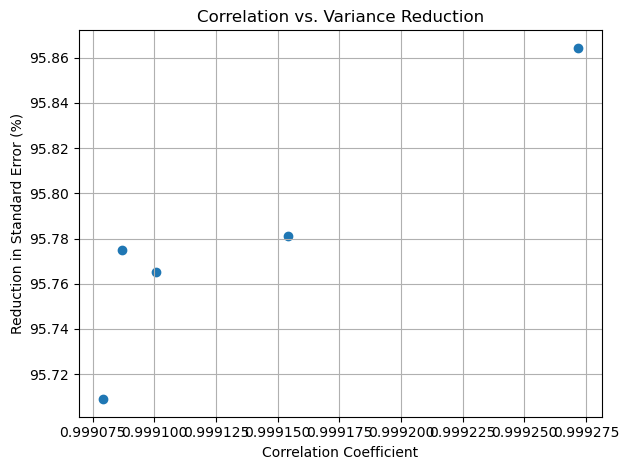

Pearson correlation coefficient between correlation and variance reduction: 0.9145
P-value: 0.0296


In [56]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Gather data for plotting
correlations = [result['Correlation Coefficient'] for result in results]
std_errors_basic = [result['Basic Std Error'] for result in results]
std_errors_enhanced = [result['Enhanced Std Error'] for result in results]
std_reduction_percentages = [(1 - (e / b)) * 100 for b, e in zip(std_errors_basic, std_errors_enhanced)]


# Plot Correlation vs. Variance Reduction
plt.scatter(correlations, std_reduction_percentages)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Reduction in Standard Error (%)')
plt.title('Correlation vs. Variance Reduction')
plt.grid(True)

plt.tight_layout()
plt.show()

# Statistical correlation
corr_coef, p_value = pearsonr(correlations, std_reduction_percentages)
print(f"Pearson correlation coefficient between correlation and variance reduction: {corr_coef:.4f}")
print(f"P-value: {p_value:.4f}")